<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Metabo2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Fundus_metabolic**


In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Mount Google Drive if the CSV is in your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**元データの分析**

In [ ]:
# Load the CSV file (adjust the path if necessary)
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'  # Adjust this to your actual file path
data = pd.read_csv(file_path)

# Display basic statistics
print("Basic statistics of the dataset:")
print(data.describe())

# Drop non-numeric columns for correlation analysis
numeric_data = data.drop(columns=["filename"])

# Calculate and display the correlation matrix
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [4]:
####
# 他のデータからGradient Boostingを用いてMETSを予測すると、精度は99%以上とかなり高い
####

# Prepare the data for training (remove the filename and target column)
X = numeric_data.drop(columns=["METS"])
y = numeric_data["METS"]

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='accuracy')

# Display the cross-validation results
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

5-Fold Cross-Validation Accuracy Scores: [0.993 0.991 1.    1.    1.   ]
Mean Accuracy: 0.9968


In [6]:
#########
# 重要なTOP3指標を抜き出してみる --> AC（腹囲), TG（中性脂肪）, BS（空腹時血糖）
#########

# Train the Gradient Boosting model
gb_model.fit(X, y)

# Get feature importances from the Gradient Boosting model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances for Gradient Boosting:")
print(feature_importances)


Feature Importances for Gradient Boosting:
  Feature  Importance
1      AC    0.432137
5      TG    0.242165
6      BS    0.147832
2     SBP    0.093333
4    HDLC    0.046051
3     DBP    0.038421
0     age    0.000062


In [7]:
### TOP3だけで予測すると物足りない
# Select only the top 3 features: AC, TG, BS
X_top3 = data[['AC', 'TG', 'BS']]

# Perform 5-fold cross-validation using only these 3 features with Gradient Boosting
cv_scores_top3 = cross_val_score(gb_model, X_top3, y, cv=5, scoring='accuracy')

# Display the cross-validation results
cv_scores_top3, cv_scores_top3.mean()


(array([0.939, 0.918, 0.951, 0.945, 0.932]), 0.9369999999999999)

In [8]:
### TOP1の腹囲をDropしてもそれなりに結果は良い
# Drop the AC feature
X_drop_AC = data.drop(columns=["filename", "METS", "AC"])

# Perform 5-fold cross-validation without AC using Gradient Boosting
cv_scores_drop_AC = cross_val_score(gb_model, X_drop_AC, y, cv=5, scoring='accuracy')

# Display the cross-validation results
cv_scores_drop_AC, cv_scores_drop_AC.mean()


(array([0.947, 0.945, 0.956, 0.955, 0.614]), 0.8834)

#**Strategy**

1. 単純にbinaryでend-to-endする

2. 各項目を別個に数値として回帰させて、gradient boostingで予測

3. Multiple instance learning?

#**気がついたこと**

1. 病気の眼が混ざっている: DR, 黄斑上膜, 硝子体混濁, 白内障など。精度向上のため、Trainsetからは眼底が見えない症例は除外する。Testsetでも眼底が写っていない写真が3つぐらいあるが、これらの扱いについては後ほど考える。

2. 今回はすべて右眼である

3. 近視度数や白内障による白濁など、眼底の色が様々である。これらの情報はそれなりに役立ちそうなので、推測する項目によっては残しておいた方が良いような気がする。




#**Image Preprocessing**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_1/img00032465_00_1R.jpg"

img = cv2.imread(img_path)
cv2_imshow(img)

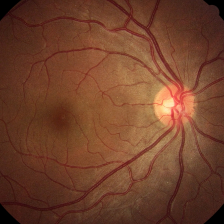

In [15]:
import cv2
from google.colab.patches import cv2_imshow

def crop_center_image(cv2_img, crop_size=900):
    # 画像のサイズを取得
    height, width, _ = cv2_img.shape

    # 中心座標を計算
    center_x = width // 2
    center_y = height // 2

    # 切り抜きの開始座標を計算
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2

    # 画像の切り抜き
    cropped_img = cv2_img[start_y:start_y + crop_size, start_x:start_x + crop_size]

    return cropped_img

def resize_image(cv2_img, size=(224, 224)):
    # リサイズ
    resized_img = cv2.resize(cv2_img, size)
    return resized_img

# 使用例
img = cv2.imread(img_path)  # 画像パスに合わせて指定
cropped_img = crop_center_image(img)  # 900x900pxで切り抜き
resized_img = resize_image(cropped_img)  # 224x224pxにリサイズ

# 切り抜いてリサイズした画像の表示
cv2_imshow(resized_img)


###**トレーニング画像を縮小**

In [ ]:
"""
画像リサイズスクリプト

このスクリプトは、指定された複数のディレクトリから全ての画像を読み込み、
以下の処理を行います：
1. 画像の中央部分を900x900ピクセルで切り抜き
2. 切り抜いた画像を224x224ピクセルにリサイズ
3. 処理した画像を新しい出力ディレクトリに保存

主な機能：
- 複数の入力ディレクトリから全ての画像を読み込む
- 画像の中央部分を切り抜く（crop_center_image関数）
- 画像をリサイズする（resize_image関数）
- 処理済み画像を新しいディレクトリに保存
- 詳細な進捗状況の表示

注意：
- 対応している画像形式は.png、.jpg、.jpegです
- Google Colab環境での実行を想定しています
"""

import os
import cv2
from tqdm import tqdm

def crop_center_image(cv2_img, crop_size=900):
    height, width, _ = cv2_img.shape
    center_x = width // 2
    center_y = height // 2
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2
    cropped_img = cv2_img[start_y:start_y + crop_size, start_x:start_x + crop_size]
    return cropped_img

def resize_image(cv2_img, size=(224, 224)):
    resized_img = cv2.resize(cv2_img, size)
    return resized_img

# 入力ディレクトリと出力ディレクトリの設定
input_dirs = [f"/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_{i}" for i in range(1, 11)]
output_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

# 出力ディレクトリが存在しない場合は作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 全画像ファイルのリストを作成
all_image_files = []
for input_dir in input_dirs:
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_image_files.extend([(input_dir, f) for f in image_files])

# 進捗バーの設定
total_images = len(all_image_files)
pbar = tqdm(total=total_images, desc="画像処理", unit="枚")

# 全ての画像を処理
for input_dir, filename in all_image_files:
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # 画像の読み込み、クロップ、リサイズ
    img = cv2.imread(input_path)
    cropped_img = crop_center_image(img)
    resized_img = resize_image(cropped_img)

    # 処理した画像を保存
    cv2.imwrite(output_path, resized_img)

    # 進捗バーの更新
    pbar.update(1)

# 進捗バーの終了
pbar.close()

print(f"\n処理完了: 合計 {total_images} 枚の画像を処理しました。")

画像処理:  31%|███▏      | 1569/5000 [15:35<43:59,  1.30枚/s]

#**simple classification**

まずは、中央を900x900で切り抜いた後に224x224に縮小した画像でbinaryな分類を試みる

In [ ]:
!pip install timm

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

dataset = FundusDataset(csv_file, img_dir, transform=transform)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

# モデルの定義
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 2)  # 2クラス分類

    def forward(self, x):
        return self.resnet(x)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニング関数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 評価関数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# トレーニングループ
num_epochs = 50
early_stopping = EarlyStopping(patience=10)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 40)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 最終評価
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 訓練結果のグラフ表示
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Creating image index...


KeyboardInterrupt: 